In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
from scipy.stats import stats
import matplotlib.image as mpimg

# Etape 1 : étude de faisabilité et rendu

In [2]:
ROOT = '/media/gael/DATA_2/Projet_DataScientest/data/raw/annotated_regions/' # Je s'appelle Root
TARGET_PATH = '/media/gael/DATA_2/Projet_DataScientest/data/raw/train_annotations.csv' # Chemin à changer en fonction de l'utilisateur
RAW = '/media/gael/DATA_2/Projet_DataScientest/data/raw/'
RESIZED = '/media/gael/DATA_2/Projet_DataScientest/data/raw/resized_regions/'

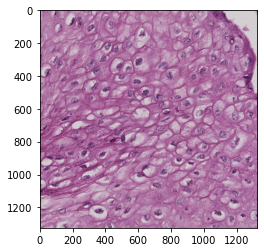

In [3]:
img = cv2.cvtColor(cv2.imread(ROOT+'C01_B003_S01_0.jpeg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Now, I will split the image into 3 channels and display each image:

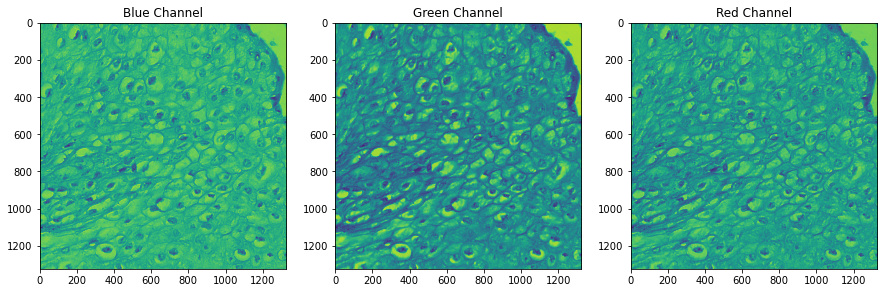

In [5]:
#Splitting into channels
blue,green,red = cv2.split(img)# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

In [6]:
blue_temp_df = pd.DataFrame(data = blue)
blue_temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324
0,218,228,204,170,160,157,160,179,181,151,...,214,183,160,149,140,149,131,156,180,160
1,206,204,184,168,167,157,155,171,170,151,...,215,184,161,151,142,153,140,165,190,177
2,198,188,173,175,181,171,163,174,167,163,...,216,185,162,153,147,149,138,160,185,180
3,190,185,177,181,188,186,181,181,171,177,...,215,187,166,157,150,133,123,138,159,159
4,180,184,183,176,177,190,192,180,164,176,...,210,185,168,159,150,123,113,118,133,141


On normalise chaque layer.

In [7]:
df_blue = blue/255
df_green = green/255
df_red = red/255

In [44]:
n_comp = 300

In [45]:
pca_b = PCA(n_components=n_comp)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=n_comp)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=n_comp)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

In [46]:
print(trans_pca_b.shape)
print(trans_pca_r.shape)
print(trans_pca_g.shape)

(1325, 300)
(1325, 300)
(1325, 300)


In [47]:
print("Blue Channel : {:.2f}%".format(sum(pca_b.explained_variance_ratio_)))
print("Green Channel: {:.2f}%".format(sum(pca_g.explained_variance_ratio_)))
print("Red Channel  : {:.2f}%".format(sum(pca_r.explained_variance_ratio_)))

Blue Channel : 0.98%
Green Channel: 0.99%
Red Channel  : 0.98%


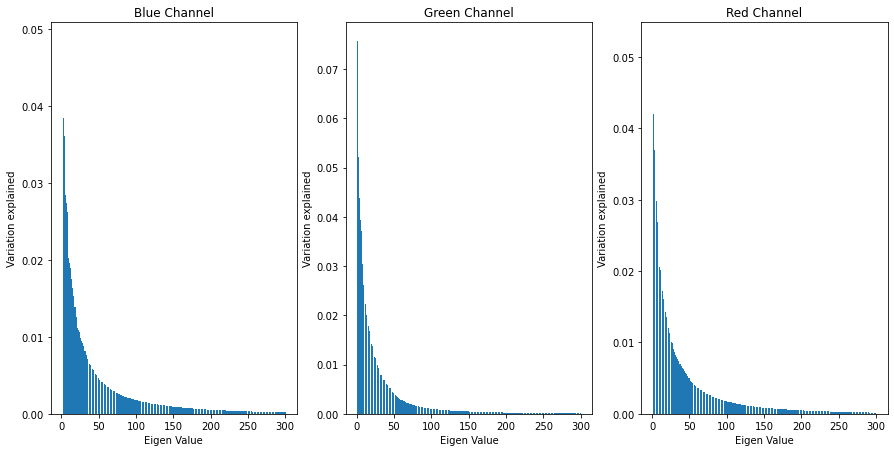

In [17]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,301)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,301)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,301)),pca_r.explained_variance_ratio_)
plt.show()

In [18]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(1325, 1325) (1325, 1325) (1325, 1325)


In [19]:
img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

(1325, 1325, 3)


In [30]:
img_reduced=img_reduced*255

In [32]:
img_reduced = img_reduced.astype('int')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


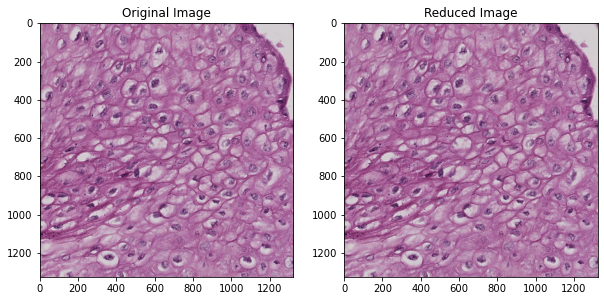

In [34]:
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

C'est plutôt satisfaisant !

# Etape 2 : Généralisation et simplification

L'objectif de ce code est de remplacer le data set d'images par un dataframe optimisé permettant des calculs plus rapides.

### **The Weighted Method**

The weighted method, also called luminosity method, weighs red, green and blue according to their wavelengths.  
The improved formula is as follows:

**Grayscale  = 0.299R + 0.587G + 0.114B**

[Source](https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/)

In [42]:
# Méthode un peu moins bourrin que la moyenne vue sur DataScientest : Grayscale = (R + G + B ) / 3.
coef_gs = {'r':0.299,
           'g':0.587,
           'b':0.114}

In [ ]:
def make_my_dataset_sexy(path, labels, dict_color = {'r':0.3334, 'g':0.3334, 'b':0.3334}):
    """
    Cette fonction prend en argument le chemin du dataset, comprime les images
    avec une PCA simple, concatène les images dans un dataframe pandas ou cudnn
    """
    
    img = cv2.cvtColor(cv2.imread(path+'C01_B003_S01_0.jpeg'), cv2.COLOR_BGR2RGB)
    
    return df